In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

Extent       Date
0     376618.799 1979-01-01
1     211788.726 1979-02-01
2     262868.141 1979-03-01
3     698377.304 1979-04-01
4    1252407.727 1979-05-01
..           ...        ...
533  1520776.003 2023-06-01
534  2076164.165 2023-07-01
535  2731799.027 2023-08-01
536  3179384.692 2023-09-01
537  3301335.210 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 12s 149ms/step - loss: 0.2378 - root_mean_squared_error: 0.4876 - val_loss: 0.1425 - val_root_mean_squared_error: 0.3776
Epoch 2/50
53/53 [==============================] - 7s 130ms/step - loss: 0.0912 - root_mean_squared_error: 0.3019 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2186
Epoch 3/50
53/53 [==============================] - 7s 129ms/step - loss: 0.0513 - root_mean_squared_error: 0.2264 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1959
Epoch 4/50
53/53 [==============================] - 8s 152ms/step - loss: 0.0402 - root_mean_squared_error: 0.2006 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1767
Epoch 5/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0336 - root_mean_squared_error: 0.1833 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1687
Epoch 6/50
53/53 [==============================] - 7s 138ms/step - loss: 0.0299 - root_mean_squared_error: 0.1729 - val_loss: 0.0250 - val

53/53 [==============================] - 10s 189ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 31/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 32/50
53/53 [==============================] - 10s 193ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 33/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 35/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.0112 - val_root

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.1547267238299055 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

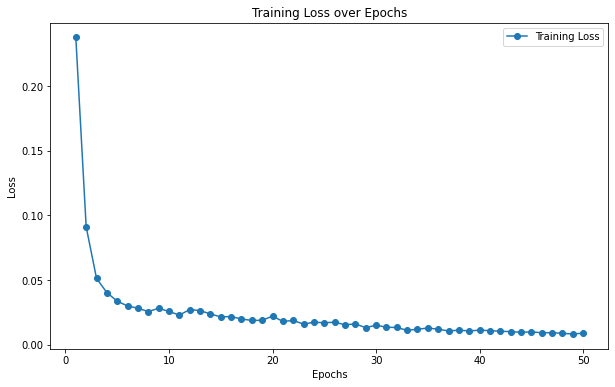

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

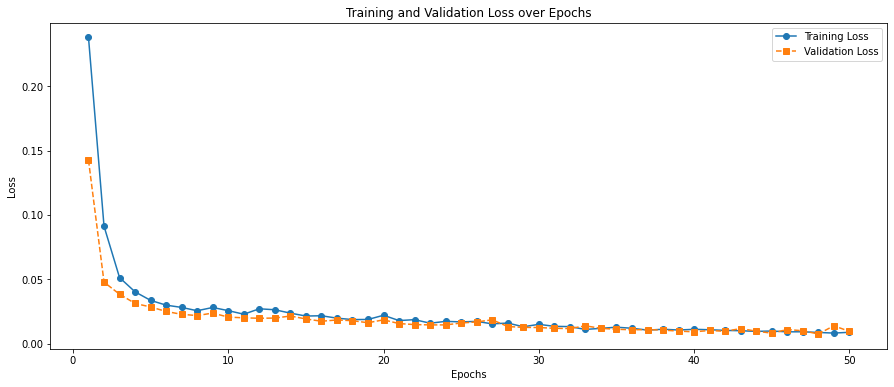

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07133756448131685
MAE : 0.06166869555788194


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0        3.066436e+06    3151724.833
1        3.362842e+06    3719188.531
2        3.310633e+06    3636501.241
3        2.760599e+06    2526913.818
4        1.584693e+06    1128752.378
5        4.518431e+05     522831.371
6        7.150107e+04     346601.304
7        1.549598e+05     444914.605
8        4.591412e+05     827036.916
9        9.403316e+05    1142021.216
10       1.559380e+06    1885693.654
11       2.236852e+06    2542569.663
12       2.789395e+06    3107373.845
13       3.064840e+06    3488175.444
14       3.074772e+06    3746306.528
15       2.564026e+06    2942322.822
16       1.324442e+06    1507212.955
17       3.071724e+05     648507.437
18       7.713394e+04     352564.010
19       2.044171e+05     453587.503
20       5.321372e+05     841043.793
21       1.057088e+06    1433155.266
22       1.723892e+06    2163687.646
23       2.426898e+06    2848863.133
24       2.966130e+06    3420877.229
25       3.279254e+06    3752886.938
26       3.249004e+06    3778951.818
27       2.797374e+06    2892177.223
28       1.682630e+06    1467610.428
29       5.742553e+05     377930.941
30       1.714300e+05     146440.376
31       2.895893e+05     244356.473
32       7.250668e+05     612217.566
33       1.327228e+06    1261627.075
34       2.070358e+06    1720565.225
35       2.802188e+06    2564005.541
36       3.341337e+06    2983773.529
37       3.599784e+06    3372645.223
38       3.471495e+06    3589687.043
39       2.899401e+06    2669385.189
40       1.607197e+06    1095398.946
41       4.407493e+05     319828.826
42       7.920505e+04     162541.182
43       1.597277e+05     179564.232
44       4.817824e+05     593196.107
45       9.672057e+05    1053508.835
46       1.600999e+06    1520776.003
47       2.274027e+06    2076164.165
48       2.810744e+06    2731799.027
49       3.050087e+06    3179384.692
50       2.997564e+06    3301335.210

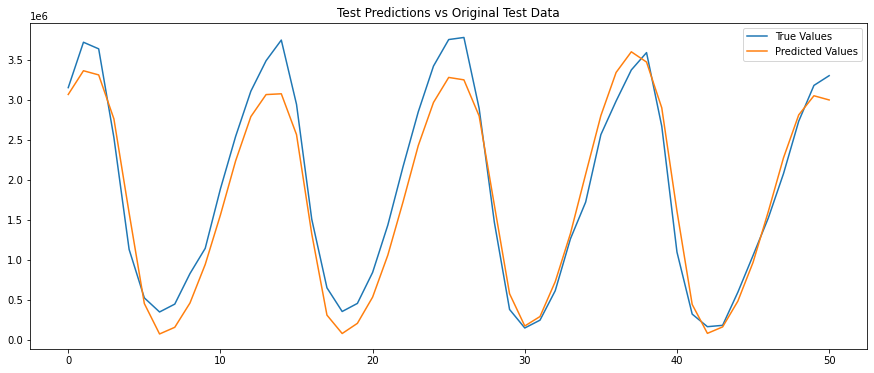

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

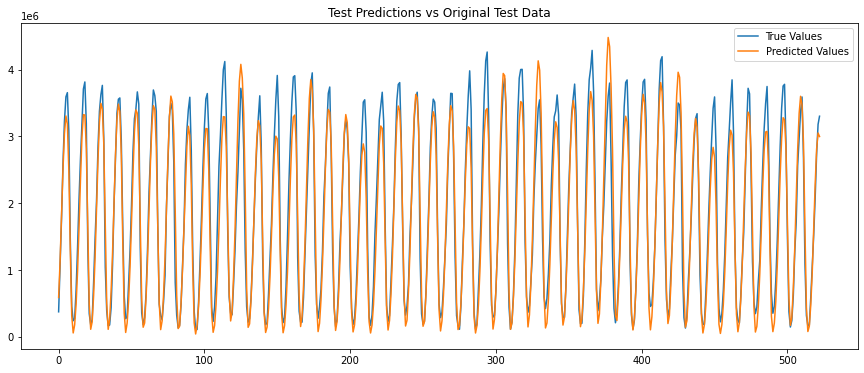

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()